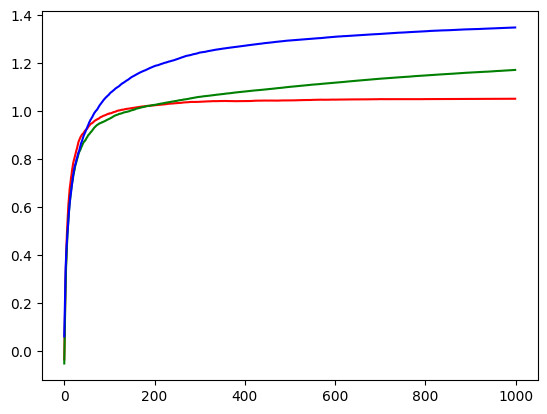

In [163]:
import matplotlib.pyplot as plt
import numpy as np

for k in range(500):
    a = np.random.normal(0,1,10)
    r = np.array([0.0]*10)
    rcount = np.array([0]*10)
    avr = 0
    avr_list = []
    for i in range(1000):    
        w = np.array([],dtype=np.float64)
        for j in range(r.shape[0]):
            if r[j] == np.max(r):
                w = np.concatenate((w,np.array([j])),axis=0)
        w = int(np.random.choice(w))
        rcount[w] += 1
        rt = np.random.choice(np.random.normal(a[w],1,100))
        r[w] = r[w] + (1/rcount[w])*(rt - r[w])
        avr = avr + (1/(i+1))*(rt - avr)
        avr_list.append(avr)
    if k == 0:
        avr_list_np = np.array(avr_list)
    else:
        avr_list_np += np.array(avr_list)
plt.plot(avr_list_np/500,'r')

for k in range(500):
    a = np.random.normal(0,1,10)
    r = np.array([0.0]*10)
    rcount = np.array([0]*10)
    avr = 0
    avr_list = []
    for i in range(1000):    
        w = np.array([])
        for j in range(r.shape[0]):
            if r[j] == np.max(r):
                w = np.concatenate((w,np.array([j])),axis=0)
        w = int(np.random.choice(w))
        if np.random.randint(100) < 1:
            w = np.random.randint(10)
        rcount[w] += 1
        rt = np.random.choice(np.random.normal(a[w],1,100))
        
        r[w] = r[w] + (1/rcount[w])*(rt - r[w])
        avr = avr + (1/(i+1))*(rt - avr)
        avr_list.append(avr)
    if k == 0:
        avr_list_np = np.array(avr_list)
    else:
        avr_list_np += np.array(avr_list)
plt.plot(avr_list_np/500,'g')

for k in range(500):
    a = np.random.normal(0,1,10)
    r = np.array([0.0]*10)
    rcount = np.array([0]*10)
    avr = 0
    avr_list = []
    for i in range(1000):    
        w = np.array([])
        for j in range(r.shape[0]):
            if r[j] == np.max(r):
                w = np.concatenate((w,np.array([j])),axis=0)
        w = int(np.random.choice(w))
        if np.random.randint(10) < 1:
            w = np.random.randint(10)
        rcount[w] += 1
        rt = np.random.choice(np.random.normal(a[w],1,100))
        r[w] = r[w] + (1/rcount[w])*(rt - r[w])
        avr = avr + (1/(i+1))*(rt - avr)
        avr_list.append(avr)
    if k == 0:
        avr_list_np = np.array(avr_list)
    else:
        avr_list_np += np.array(avr_list)
plt.plot(avr_list_np/500,'b')

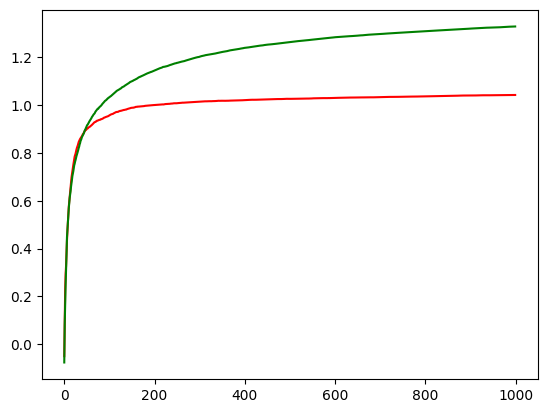

In [167]:
for k in range(500):
    a = np.random.normal(0,1,10)
    r = np.array([0.0]*10)
    rcount = np.array([0]*10)
    avr = 0
    avr_list = []
    for i in range(1000):
        a += np.random.normal(0,0.01,10)
        w = np.array([],dtype=np.float64)
        for j in range(r.shape[0]):
            if r[j] == np.max(r):
                w = np.concatenate((w,np.array([j])),axis=0)
        w = int(np.random.choice(w))
        rcount[w] += 1
        rt = np.random.choice(np.random.normal(a[w],1,100))
        r[w] = r[w] + (1/rcount[w])*(rt - r[w])
        avr = avr + (1/(i+1))*(rt - avr)
        avr_list.append(avr)
    if k == 0:
        avr_list_np = np.array(avr_list)
    else:
        avr_list_np += np.array(avr_list)
plt.plot(avr_list_np/500,'r')

for k in range(500):
    a = np.random.normal(0,1,10)
    r = np.array([0.0]*10)
    rcount = np.array([0]*10)
    avr = 0
    avr_list = []
    for i in range(1000):
        a += np.random.normal(0,0.01,10)
        w = np.array([])
        for j in range(r.shape[0]):
            if r[j] == np.max(r):
                w = np.concatenate((w,np.array([j])),axis=0)
        w = int(np.random.choice(w))
        if np.random.randint(10) < 1:
            w = np.random.randint(10)
        rcount[w] += 1
        rt = np.random.choice(np.random.normal(a[w],1,100))
        
        r[w] = r[w] + (1/rcount[w])*(rt - r[w])
        avr = avr + (1/(i+1))*(rt - avr)
        avr_list.append(avr)
    if k == 0:
        avr_list_np = np.array(avr_list)
    else:
        avr_list_np += np.array(avr_list)
plt.plot(avr_list_np/500,'g')

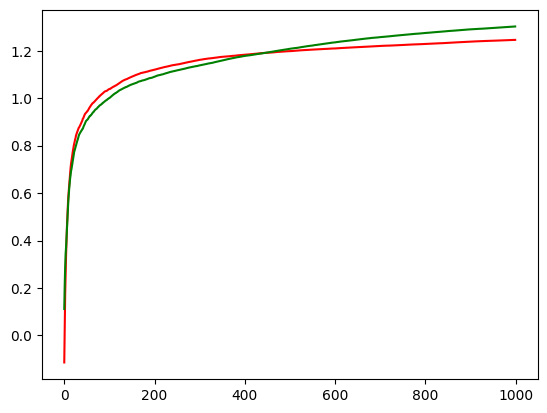

In [168]:
for k in range(500):
    a = np.random.normal(0,1,10)
    r = np.array([0.0]*10)
    rcount = np.array([0]*10)
    avr = 0
    avr_list = []
    for i in range(1000):
        a += np.random.normal(0,0.01,10)
        w = np.array([],dtype=np.float64)
        for j in range(r.shape[0]):
            if r[j] == np.max(r):
                w = np.concatenate((w,np.array([j])),axis=0)
        w = int(np.random.choice(w))
        rcount[w] += 1
        rt = np.random.choice(np.random.normal(a[w],1,100))
        r[w] = r[w] + (0.1)*(rt - r[w])
        avr = avr + (1/(i+1))*(rt - avr)
        avr_list.append(avr)
    if k == 0:
        avr_list_np = np.array(avr_list)
    else:
        avr_list_np += np.array(avr_list)
plt.plot(avr_list_np/500,'r')

for k in range(500):
    a = np.random.normal(0,1,10)
    r = np.array([0.0]*10)
    rcount = np.array([0]*10)
    avr = 0
    avr_list = []
    for i in range(1000):
        a += np.random.normal(0,0.01,10)
        w = np.array([])
        for j in range(r.shape[0]):
            if r[j] == np.max(r):
                w = np.concatenate((w,np.array([j])),axis=0)
        w = int(np.random.choice(w))
        if np.random.randint(10) < 1:
            w = np.random.randint(10)
        rcount[w] += 1
        rt = np.random.choice(np.random.normal(a[w],1,100))
        
        r[w] = r[w] + (0.1)*(rt - r[w])
        avr = avr + (1/(i+1))*(rt - avr)
        avr_list.append(avr)
    if k == 0:
        avr_list_np = np.array(avr_list)
    else:
        avr_list_np += np.array(avr_list)
plt.plot(avr_list_np/500,'g')